In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from model_explore.pytorch.localize import on_cpu
from model_explore.pytorch import evaluate
import matplotlib.pyplot as plt
import numpy as np
import copick

In [3]:
copick_config_path = "/mnt/simulations/ml_challenge/ml_config.json"
root = copick.from_file(copick_config_path)

objects = []
for obj in root.pickable_objects:
    if obj.is_particle:
        objects.append((obj.name, obj.label, obj.radius))

In [4]:
run = root.get_run('TS_17')

on_cpu.processs_localization(
    run, 
    objects,
    'prediction',
    method='watershed',
    filter_size = 10, 
)

IndexError: list index out of range

In [4]:
run = root.get_run('TS_17')

tomo = run.get_voxel_spacing(10).get_tomogram('wbp').numpy()
seg = run.get_segmentations(name='prediction')[0].numpy()

In [ ]:
run.get_segmentations()

In [5]:
def get_copick_coordinates(copick_run,        # CoPick run object containing the segmentation data
                           name: str,         # Name of the object or protein for which coordinates are being extracted
                           user_id: str,      # Identifier of the user or project that generated the picks
                           voxel_size: float  # Voxel size of the tomogram, used for scaling the coordinates
                           ):
                           
    # Retrieve the pick points associated with the specified object and user ID
    points = copick_run.get_picks(object_name=name, user_id=user_id)[0].points
    
    # Initialize an array to store the coordinates
    nPoints = len(points)                      # Number of points retrieved
    coordinates = np.zeros([len(points), 3])   # Create an empty array to hold the (z, y, x) coordinates

    # Iterate over all points and convert their locations to coordinates in voxel space
    for ii in range(nPoints):
        coordinates[ii,] = [points[ii].location.z / voxel_size,   # Scale z-coordinate by voxel size
                            points[ii].location.y / voxel_size,   # Scale y-coordinate by voxel size
                            points[ii].location.x / voxel_size]   # Scale x-coordinate by voxel size
    
    # Return the array of coordinates
    return coordinates

286
284
121
25
99
28


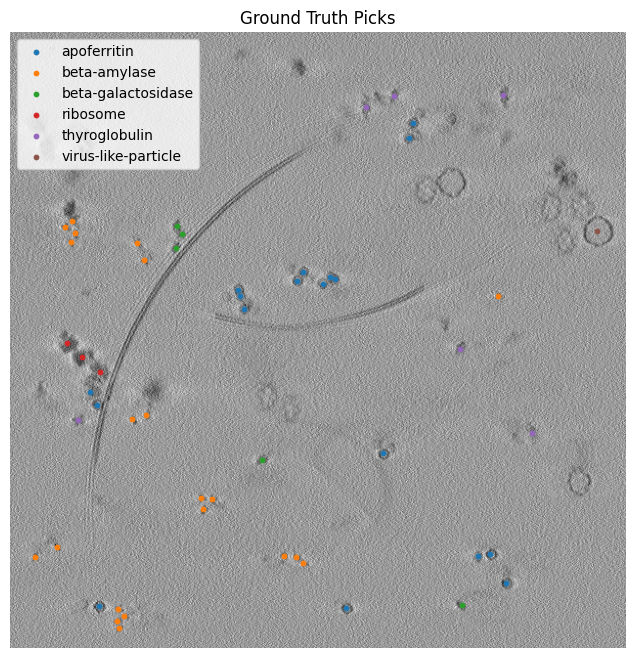

In [8]:
# Tomogram Slice to Display
volSlice = 90

voxel_size = 10

# Plot the images
plt.figure(figsize=(8, 8))

# Original Image
# plt.subplot(1, 2, 1)
plt.title('Ground Truth Picks')
plt.imshow(tomo[volSlice,],cmap='gray')
plt.axis('off')

# Plot each object from ground truth data
for obj in objects:
    
    # Retrieve the pick points for the current object from ground truth data
    points = run.get_picks(object_name=obj[0], user_id='polnet')[0].points
    
    nPoints = len(points)                    # Number of points retrieved
    coordinates = np.zeros([len(points), 3]) # Initialize an array for the coordinates

    print(nPoints)

    # Convert the locations of each point to voxel space coordinates
    for ii in range(nPoints):
        coordinates[ii,] = [points[ii].location.z / voxel_size,  # Scale z-coordinate by voxel size
                            points[ii].location.y / voxel_size,  # Scale y-coordinate by voxel size
                            points[ii].location.x / voxel_size]  # Scale x-coordinate by voxel size
    
    # Find points that are closest to the slice at Z = volSlice (90)
    slice_proximity_threshold = 5  # Threshold for how close a point needs to be to the slice to be considered
    close_points = coordinates[np.abs(coordinates[:, 0] - volSlice) <= slice_proximity_threshold]

    # Plot the points on the image
    plt.scatter(close_points[:, 2], close_points[:, 1], label=obj[0], s=10)

plt.legend()

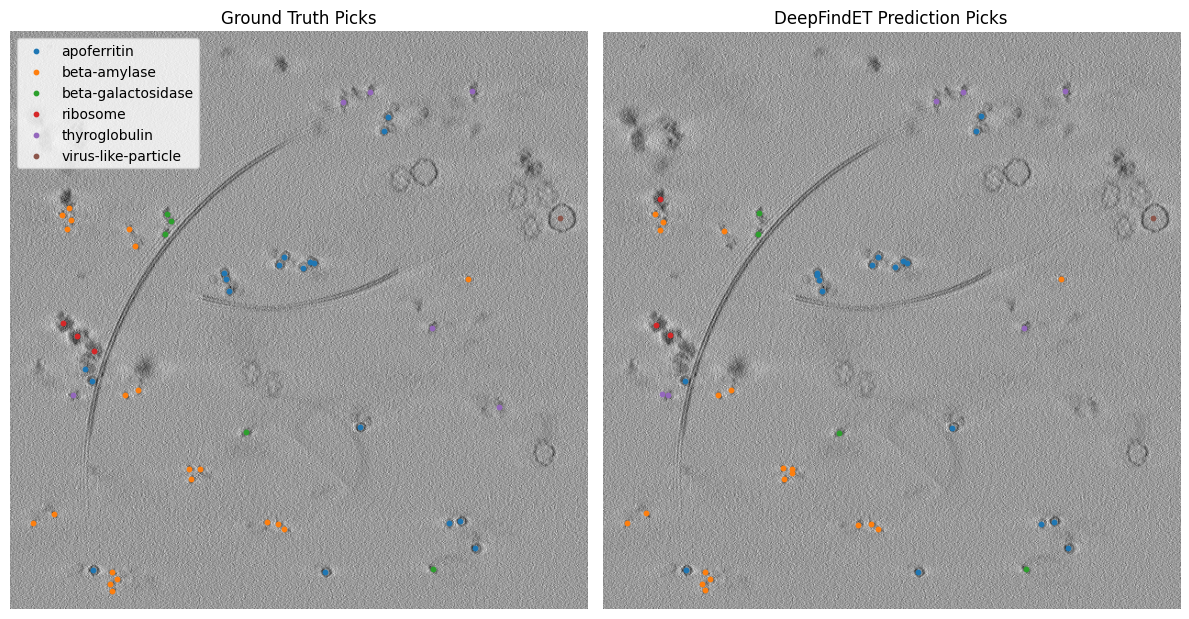

In [ ]:
# Tomogram Slice to Display
volSlice = 90

voxel_size = 10

# Plot the images
plt.figure(figsize=(12, 12))

# Original Image
plt.subplot(1, 2, 1)
plt.title('Ground Truth Picks')
plt.imshow(tomo[volSlice,],cmap='gray')
plt.axis('off')

# Plot each object from ground truth data
for obj in objects:
    
    # Retrieve the pick points for the current object from ground truth data
    points = run.get_picks(object_name=obj[0], user_id='polnet')[0].points
    
    nPoints = len(points)                    # Number of points retrieved
    coordinates = np.zeros([len(points), 3]) # Initialize an array for the coordinates

    # Convert the locations of each point to voxel space coordinates
    for ii in range(nPoints):
        coordinates[ii,] = [points[ii].location.z / voxel_size,  # Scale z-coordinate by voxel size
                            points[ii].location.y / voxel_size,  # Scale y-coordinate by voxel size
                            points[ii].location.x / voxel_size]  # Scale x-coordinate by voxel size
    
    # Find points that are closest to the slice at Z = volSlice (90)
    slice_proximity_threshold = 5  # Threshold for how close a point needs to be to the slice to be considered
    close_points = coordinates[np.abs(coordinates[:, 0] - volSlice) <= slice_proximity_threshold]

    # Plot the points on the image
    plt.scatter(close_points[:, 2], close_points[:, 1], label=obj[0], s=10)

plt.legend()

# Predicted Picks Image
plt.subplot(1, 2, 2)
plt.title('DeepFindET Prediction Picks')
plt.imshow(tomo[volSlice,],cmap='gray')
plt.axis('off')

# Plot each object from DeepFindET predictions
for obj in objects:
    
    # Retrieve the pick points for the current object from ground truth data
    points = run.get_picks(object_name=obj[0], user_id='monai')[0].points
    
    nPoints = len(points)                    # Number of points retrieved
    coordinates = np.zeros([len(points), 3]) # Initialize an array for the coordinates

    # Convert the locations of each point to voxel space coordinates
    for ii in range(nPoints):
        coordinates[ii,] = [points[ii].location.z / voxel_size,  # Scale z-coordinate by voxel size
                            points[ii].location.y / voxel_size,  # Scale y-coordinate by voxel size
                            points[ii].location.x / voxel_size]  # Scale x-coordinate by voxel size

    # Find points that are closest to the slice at Z = volSlice (90)
    slice_proximity_threshold = 5  # Threshold for how close a point needs to be to the slice to be considered
    close_points = coordinates[np.abs(coordinates[:, 0] - volSlice) <= slice_proximity_threshold]

    # Plot the points on the image
    plt.scatter(close_points[:, 2], close_points[:, 1], label=obj[0], s=10)


# plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
filter_size = 10
radius_min_scale = 0.3
radius_max_scale = 1.7
voxel_size = 10

picks = {}
for obj in objects:


    # Extract Particle Radius from Root
    min_radius = obj[2] * radius_min_scale / voxel_size
    max_radius = obj[2] * radius_max_scale / voxel_size

    picks[obj[0]] = on_cpu.picks_from_segmentation(seg, obj[1], filter_size, min_radius, max_radius)
    
    print(f'Extracting Picks from: {obj[0]} - Total Picks: {len(picks[obj[0]])}')

Extracting Picks from: apoferritin
Extracting Picks from: beta-amylase
Extracting Picks from: beta-galactosidase
Extracting Picks from: ribosome
Extracting Picks from: thyroglobulin
Extracting Picks from: virus-like-particle


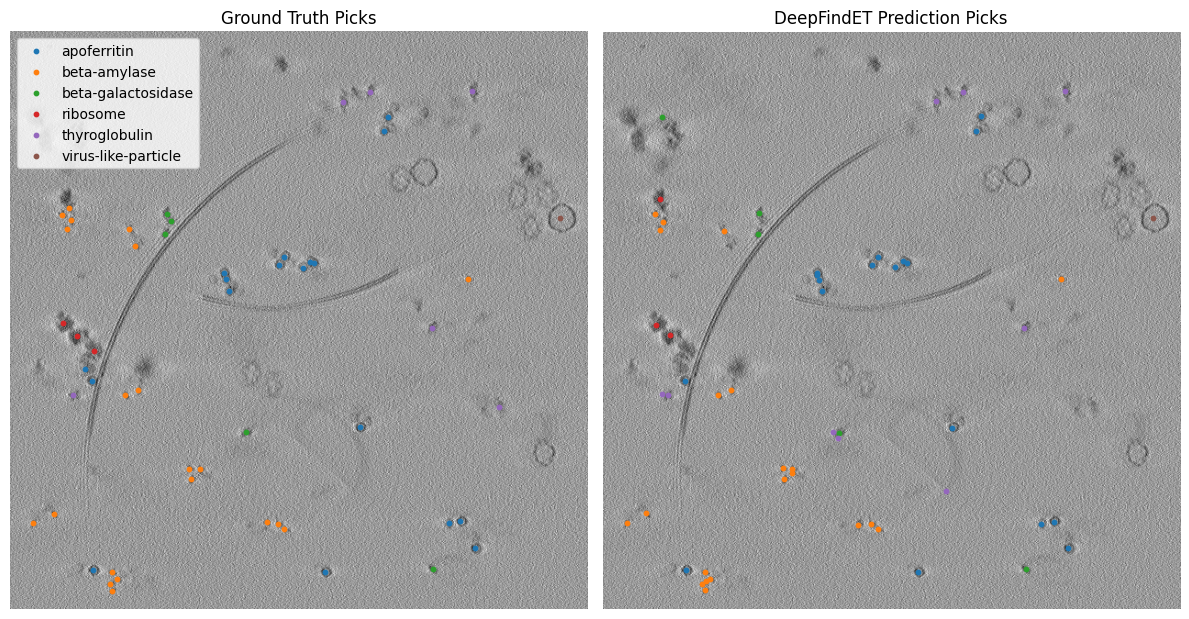

In [ ]:
# Tomogram Slice to Display
volSlice = 90

voxel_size = 10

# Plot the images
plt.figure(figsize=(12, 12))

# Original Image
plt.subplot(1, 2, 1)
plt.title('Ground Truth Picks')
plt.imshow(tomo[volSlice,],cmap='gray')
plt.axis('off')

# Plot each object from ground truth data
for obj in objects:
    
    # Retrieve the pick points for the current object from ground truth data
    points = run.get_picks(object_name=obj[0], user_id='polnet')[0].points
    
    nPoints = len(points)                    # Number of points retrieved
    coordinates = np.zeros([len(points), 3]) # Initialize an array for the coordinates

    # Convert the locations of each point to voxel space coordinates
    for ii in range(nPoints):
        coordinates[ii,] = [points[ii].location.z / voxel_size,  # Scale z-coordinate by voxel size
                            points[ii].location.y / voxel_size,  # Scale y-coordinate by voxel size
                            points[ii].location.x / voxel_size]  # Scale x-coordinate by voxel size
    
    # Find points that are closest to the slice at Z = volSlice (90)
    slice_proximity_threshold = 5  # Threshold for how close a point needs to be to the slice to be considered
    close_points = coordinates[np.abs(coordinates[:, 0] - volSlice) <= slice_proximity_threshold]

    # Plot the points on the image
    plt.scatter(close_points[:, 2], close_points[:, 1], label=obj[0], s=10)

plt.legend()

# Predicted Picks Image
plt.subplot(1, 2, 2)
plt.title('DeepFindET Prediction Picks')
plt.imshow(tomo[volSlice,],cmap='gray')
plt.axis('off')

# Plot each object from DeepFindET predictions
for obj in objects:
    
    coordinates = np.array(picks[obj[0]])
    
    # Find points closest to the slice Z = 90
    slice_proximity_threshold = 5  # Adjust this threshold as needed
    close_points = coordinates[np.abs(coordinates[:, 0] - volSlice) <= slice_proximity_threshold]

    # Plot these points
    plt.scatter(close_points[:, 2], close_points[:, 1], label=obj[0], s=10)


# plt.legend()
plt.tight_layout()
plt.show()